In [8]:
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from PIL import Image

In [53]:
coo.data, coo.col, coo.row, coo.getcol(0), coo.has_canonical_format, coo.shape, coo.nnz

(array([2, 4, 9]),
 array([1, 4, 2], dtype=int32),
 array([1, 3, 0], dtype=int32),
 <5x1 sparse matrix of type '<class 'numpy.int64'>'
 	with 0 stored elements in Compressed Sparse Row format>,
 False,
 (5, 5),
 3)

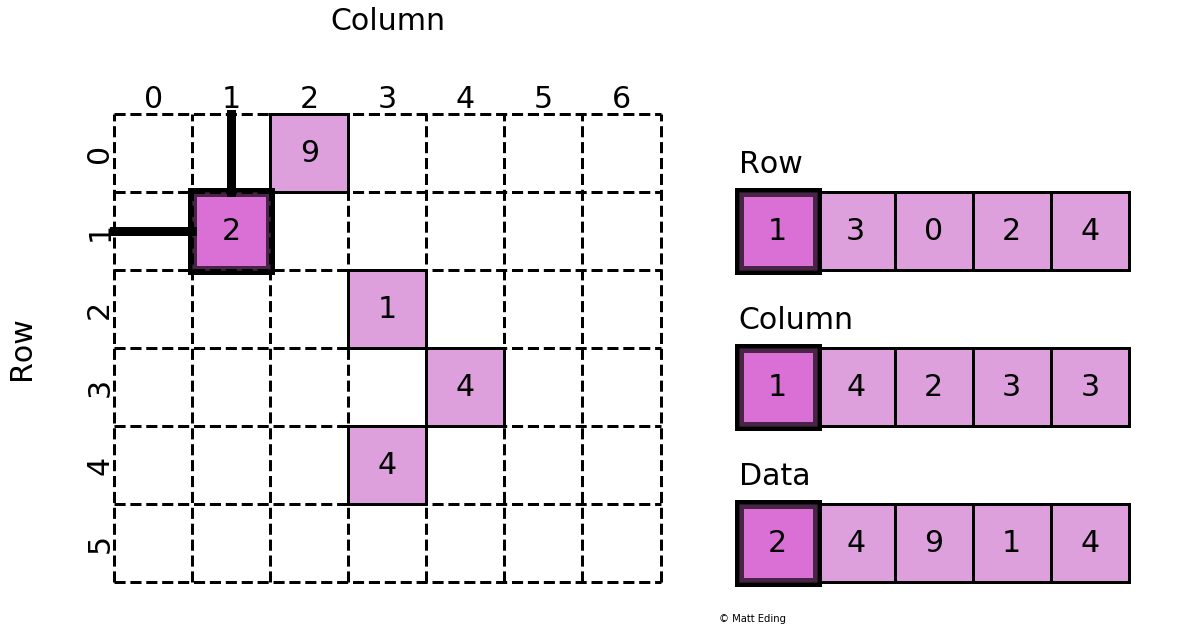

In [503]:
#: sparse matrix
row = [1, 3, 0, 2, 4]
col = [1, 4, 2, 3, 3]
data = [2, 4, 9, 1, 4]
coo = sparse.coo_matrix((data, (row, col)), shape=(10, 17))
coo = sparse.coo_matrix((data, (row, col)), shape=(6, 7))


#: figure metadata
darkcolor = 'orchid'
lightcolor = 'plum'
size = 10
plt.figure(figsize=(2*size, size))


#: plotting functions
dashed_line = partial(plt.plot, color='black', linestyle='--', linewidth=3)
highlight_line = partial(plt.plot, color='black', linestyle='-', linewidth=9)
rect_plt = partial(plt.Rectangle, width=1, height=1, edgecolor='black', linewidth=3)  #TODO: rename sqr_plt?
text_plt = partial(plt.text, fontweight=100, fontsize=(size * 3))
vert_text = partial(text_plt, rotation=90, horizontalalignment='right', verticalalignment='center')
horz_text = partial(text_plt, horizontalalignment='center', verticalalignment='bottom')
rect_text = partial(text_plt, horizontalalignment='center', verticalalignment='center')


#: dashed array grid
h, w = coo.shape
for i in range(h + 1):
    dashed_line([0, w], [i, i])
    
for j in range(w + 1):
    dashed_line([j, j], [0, h])


#: fill data values in array format
for x, y, val in zip(col, row, data):
    x, y = xy = (x, h - y - 1)
    rect = rect_plt(xy, facecolor=lightcolor)
    plt.gca().add_patch(rect)
    rect_text(x + 0.5, y + 0.5, str(val))
    

#: fill sparse format
for i, (label, info) in enumerate(zip(['Row', 'Column', 'Data'], [row, col, data])):
    text_plt((w + 1), (h - 0.75 - 2 * i), label)
    for j, val in enumerate(info):
        x, y = xy = ((w + j + 1), (h - 2 * (i + 1)))
        rect = rect_plt(xy, facecolor=lightcolor)
        plt.gca().add_patch(rect)
        rect_text(x + 0.5, y + 0.5, str(val))
    

#: side labels
vert_text(-1, (h / 2), 'Row')
for i in reversed(range(h)):
    vert_text(0, (h - i - 0.5), str(i))

horz_text((w / 2), (h + 1), 'Column')
for i in range(w):
    horz_text(i + 0.5, h, str(i))
    

#: highlight relationships
for i, (r, c) in enumerate(zip(row, col)):
    for alpha in np.linspace(0, 1, 10):
        alpha = 0.5
        for j in range(3):
            xy = ((w + i + 1), (h - 2 * (j + 1)))
            rect = rect_plt(xy, facecolor=darkcolor, alpha=alpha, linewidth=9)  # sparse part
            plt.gca().add_patch(rect)

        xy = (c, (h - r - 1))
        rect = rect_plt(xy, facecolor=darkcolor, alpha=alpha, linewidth=9)  # array part
        plt.gca().add_patch(rect)

        highlight_line([0, c], [h-r-0.5]*2, alpha=alpha)  # horz
        highlight_line([c+0.5]*2, [h-r, h], alpha=alpha)  # vert
#         break
    break


#: format graph
plt.text(7.75, -0.5, '© Matt Eding')
plt.axis('equal')
plt.axis('off');

In [289]:
coo.toarray()

array([[0, 0, 9, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [ ]:
plt.Rectangle
